In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("SeoulBikeData (1).csv",encoding='CP949')

In [2]:
data[:24]

,Date,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,Winter,No Holiday,Yes
5,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,Winter,No Holiday,Yes
6,01/12/2017,181,6,-6.6,35,1.3,2000,-19.5,0.00,0.0,0.0,Winter,No Holiday,Yes
7,01/12/2017,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,Winter,No Holiday,Yes
8,01/12/2017,930,8,-7.6,37,1.1,2000,-19.8,0.01,0.0,0.0,Winter,No Holiday,Yes
9,01/12/2017,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,Winter,No Holiday,Yes


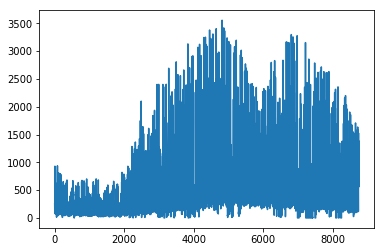

In [3]:
plt.plot(data['Rented Bike Count'])

In [4]:
data=data.drop(['Hour'],axis=1)

In [6]:
cols=data.columns[1:-3] 
len(cols)

9

In [8]:
def fill_missing(values):
    one_day = 7 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if values[row,0]==0:
                values[row,0] = values[row - one_day,0]

In [48]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)

In [49]:
fill_missing(values)

In [50]:
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [51]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [52]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [53]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)


6816
684
684


In [54]:
print(trainX.shape)
print(trainY.shape)

(6816, 168, 9)
(6816, 24)


(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd8106230b8>)

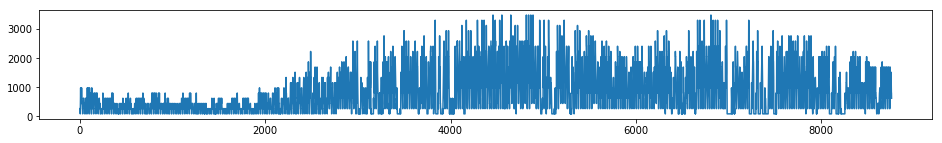

In [55]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

my_augmenter = (Quantize(n_levels=[20]))
X_aug1= my_augmenter.augment(data['Rented Bike Count'].values)
plot(X_aug1)

In [56]:
quant =scaler.fit_transform(X_aug1.reshape(-1,1))

NameError: name 'scaler' is not defined

In [57]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train_q,val_q, test_q = quant[0:train_size,:],quant[train_size:train_size+val_size,:], quant[train_size+val_size:,:]
print(len(train_q),len(val_q), len(test_q))

NameError: name 'quant' is not defined

In [58]:
def create_dataset_multistep_uni(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [59]:
look_back = 168
predict=24
trainX_q, trainY_q = create_dataset_multistep_uni(train_q, look_back,predict)
valX_q, valY_q = create_dataset_multistep_uni(val_q, look_back,predict)
testX_q, testY_q = create_dataset_multistep_uni(test_q, look_back,predict)

NameError: name 'train_q' is not defined

In [60]:
look_back = 168
predict=24
trainX_o, trainY_o = create_dataset_multistep_uni(train, look_back,predict)
valX_o, valY_o = create_dataset_multistep_uni(val, look_back,predict)
testX_o, testY_o = create_dataset_multistep_uni(test, look_back,predict)

6816
684
684


In [61]:
trainX_q = np.reshape(trainX_q, (trainX_q.shape[0], trainX_q.shape[1], 1))
valX_q = np.reshape(valX_q, (valX_q.shape[0], valX_q.shape[1],1))
testX_q = np.reshape(testX_q, (testX.shape[0],testX_q.shape[1], 1 ))

NameError: name 'trainX_q' is not defined

In [62]:
trainX_o = np.reshape(trainX_o, (trainX_o.shape[0], trainX_o.shape[1], 1))
valX_o = np.reshape(valX_o, (valX_o.shape[0], valX_o.shape[1],1))
testX_o = np.reshape(testX_o, (testX_o.shape[0],testX_o.shape[1], 1 ))

In [63]:
print(trainX.shape)
print(trainX_o.shape)

(6816, 168, 9)
(6816, 168, 1)


In [121]:
first_input = Input(shape=(168,1))
in1=layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1))(first_input)
in2=layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(6, 1))(in1)
#in3=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(in2)
in4=layers.MaxPooling1D(pool_size=2)(in2)
in5=layers.Flatten()(in4)
in5=Dropout(0.5)(in5)
in6=layers.Dense(15)(in5)
#in5=layers.Dense(1)(in5)
#in6=layers.Bidirectional(LSTM(50))(first_input)

inputs = Input(shape=(168, 9), name='inputs')
#lstm_out = Bidirectional(LSTM(80, return_sequences=False))(inputs)
lstm_out = LSTM(80,recurrent_dropout=0.3,return_sequences=False)(inputs)


#lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Attention layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([lstm_out, lstm_out])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_out])
#flat_out = Flatten()(concat_out)

    # Dense layer
#dense_out = Dense(6, activation='relu')(flat_out)
concat=layers.Concatenate()([in6, lstm_out])
#dens=layers.Dense(100,activation='relu')(concat)
#dens=layers.Dense(100)
#dens= SeqSelfAttention(attention_activation='relu')(concat)

dens=layers.Dense(24)(concat)

model=tf.keras.Model(inputs=[first_input,inputs],outputs=[dens])
model.compile(optimizer='adam', loss='mse')


In [128]:
import tensorflow.keras.backend as K


In [172]:
first_input = Input(shape=(168,1))
in1=layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1))(first_input)
in2=layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(6, 1))(in1)
#in3=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(in2)
in4=layers.MaxPooling1D(pool_size=2)(in2)
in5=layers.Flatten()(in4)
in5=Dropout(0.5)(in5)
in5= RepeatVector(168)(in5)

in6=layers.Dense(1)(in5)
#in5=layers.Dense(1)(in5)
#in6=layers.Bidirectional(LSTM(50))(first_input)

inputs = Input(shape=(168, 9), name='inputs')
#lstm_out = Bidirectional(LSTM(80, return_sequences=False))(inputs)
lstm_out = LSTM(50,recurrent_dropout=0.3,return_sequences=True)(inputs)


#lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Attention layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([lstm_out, lstm_out])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_out])
#flat_out = Flatten()(concat_out)

    # Dense layer
#dense_out = Dense(6, activation='relu')(flat_out)
concat=layers.Concatenate()([in6, lstm_out])

concat=layers.MaxPooling1D(pool_size=2,name='extractor')(concat)
concat=Flatten()(concat)
#dens=layers.Dense(100,activation='relu')(concat)
#dens=layers.Dense(100)
#dens= SeqSelfAttention(attention_activation='relu')(concat)

dens=layers.Dense(24)(concat)

model=tf.keras.Model(inputs=[first_input,inputs],outputs=[dens])
model.compile(optimizer='adam', loss='mse')


In [173]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 168, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_86 (Conv1D)              (None, 166, 64)      256         input_44[0][0]                   
__________________________________________________________________________________________________
conv1d_87 (Conv1D)              (None, 166, 64)      4160        conv1d_86[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_49 (MaxPooling1D) (None, 83, 64)       0           conv1d_87[0][0]                  
___________________________________________________________________________________________

In [174]:
checkpoint_path = "saved_weights/multi_bike_80_multistep_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [175]:
hist = model.fit([trainX_o,trainX],trainY, epochs = 20,validation_data=([valX_o,valX],valY), verbose = 1,callbacks=[cb])

Train on 6816 samples, validate on 684 samples
Epoch 1/20
 800/6816 [==>...........................] - ETA: 17s - loss: 0.0282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [165]:
model.load_weights("saved_weights/multi_bike_80_multistep_24.hdf5")

In [519]:
model.load_weights("saved_weights/multi_bike_80_multistep_24_1aug.hdf5")

In [130]:
len(testX)/24

28.5

In [172]:
import random

    #print(i,random.randint(0,37))
j=np.random.choice(28,15,replace=False).tolist()


In [91]:
j=[14, 9, 19, 10, 12, 25, 23, 3, 26, 18, 24, 15, 22, 8, 27]


In [166]:
###saved_weights/multi_bike_80_multistep_24_aug.hdf5
from math import *
from sklearn.metrics import *
aug_rm=[]
aug_ma=[]
for k in j:

    yhat = model.predict([testX_o,testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    aug_rm.append(rmse)
    aug_ma.append(mae)

    
print(np.mean(aug_rm))
print(np.mean(aug_ma))

Test MAE: 0.04814
Test RMSE: 0.06902
Test MAE: 0.04020
Test RMSE: 0.05108
Test MAE: 0.03348
Test RMSE: 0.04886
Test MAE: 0.06428
Test RMSE: 0.08629
Test MAE: 0.05253
Test RMSE: 0.07642
Test MAE: 0.03166
Test RMSE: 0.04141
Test MAE: 0.06203
Test RMSE: 0.07836
Test MAE: 0.06805
Test RMSE: 0.09816
Test MAE: 0.03192
Test RMSE: 0.04470
Test MAE: 0.03565
Test RMSE: 0.04816
Test MAE: 0.04207
Test RMSE: 0.05878
Test MAE: 0.03803
Test RMSE: 0.04765
Test MAE: 0.05993
Test RMSE: 0.09392
Test MAE: 0.08104
Test RMSE: 0.09508
Test MAE: 0.04131
Test RMSE: 0.05941
0.06648623540433408
0.048687644


In [512]:
#saved_weights/multi_bike_80_multistep_24_1.hdf5
non_aug_rm=[]
non_aug_ma=[]
for k in j:

    yhat = model.predict([testX_o,testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)


print(np.mean(non_aug_rm))
print(np.mean(non_aug_ma))

Test MAE: 0.06738
Test RMSE: 0.09994
Test MAE: 0.08507
Test RMSE: 0.09985
Test MAE: 0.04448
Test RMSE: 0.05707
Test MAE: 0.05989
Test RMSE: 0.08571
Test MAE: 0.07918
Test RMSE: 0.11277
Test MAE: 0.03293
Test RMSE: 0.04164
Test MAE: 0.03493
Test RMSE: 0.04284
Test MAE: 0.05419
Test RMSE: 0.07423
Test MAE: 0.04166
Test RMSE: 0.05655
Test MAE: 0.04419
Test RMSE: 0.05603
Test MAE: 0.02786
Test RMSE: 0.03764
Test MAE: 0.05366
Test RMSE: 0.06641
Test MAE: 0.04979
Test RMSE: 0.06269
Test MAE: 0.06109
Test RMSE: 0.07779
Test MAE: 0.05424
Test RMSE: 0.06833
0.06930003026774753
0.052701756


In [513]:
non_aug_rm

[0.09993948185573696,
 0.09985309125068602,
 0.05707120018698845,
 0.08570905960020943,
 0.11277014431242874,
 0.04164055180364262,
 0.04283911483365749,
 0.07422758037337787,
 0.056554455405706396,
 0.056032365664312064,
 0.037641128574674984,
 0.06641400165754761,
 0.06269356065602119,
 0.07778525388687865,
 0.06832946395434449]

In [514]:
np.std(non_aug_rm)

0.021811169458398644

In [515]:
np.std(non_aug_ma)

0.015675822

In [521]:
np.std(aug_rm)

0.01846379911215396

In [522]:
np.std(aug_ma)

0.014282077

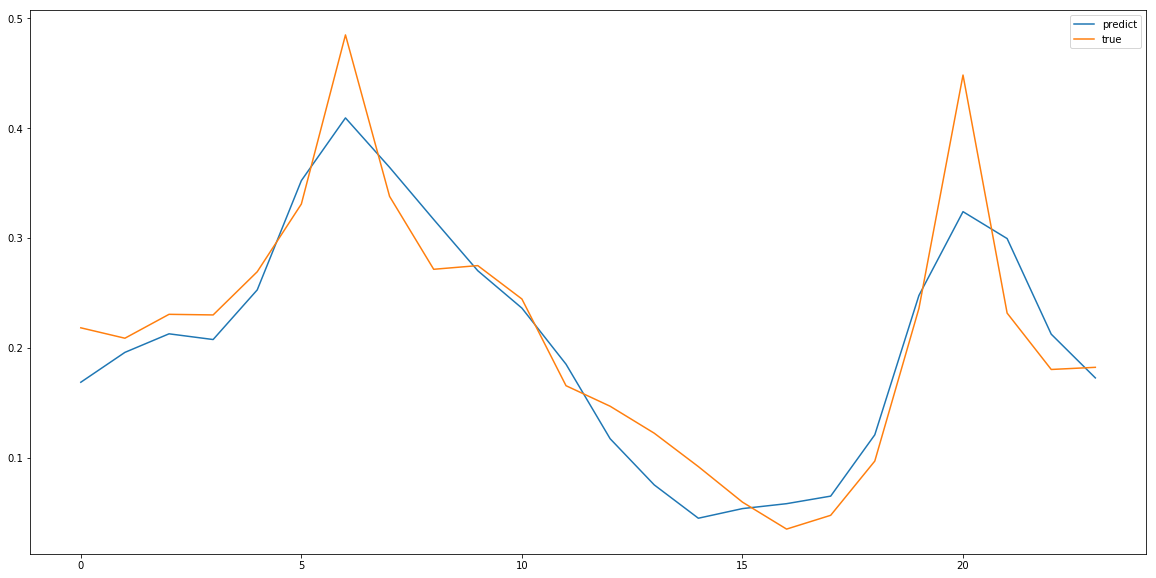

Test RMSE: 0.04141
Test MAE: 0.03166
Test MSE: 0.00171
Test RMSE: 148.52848
Test MAE: 113.56088


In [168]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX_o,testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*25]
testy=testY[24*25]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

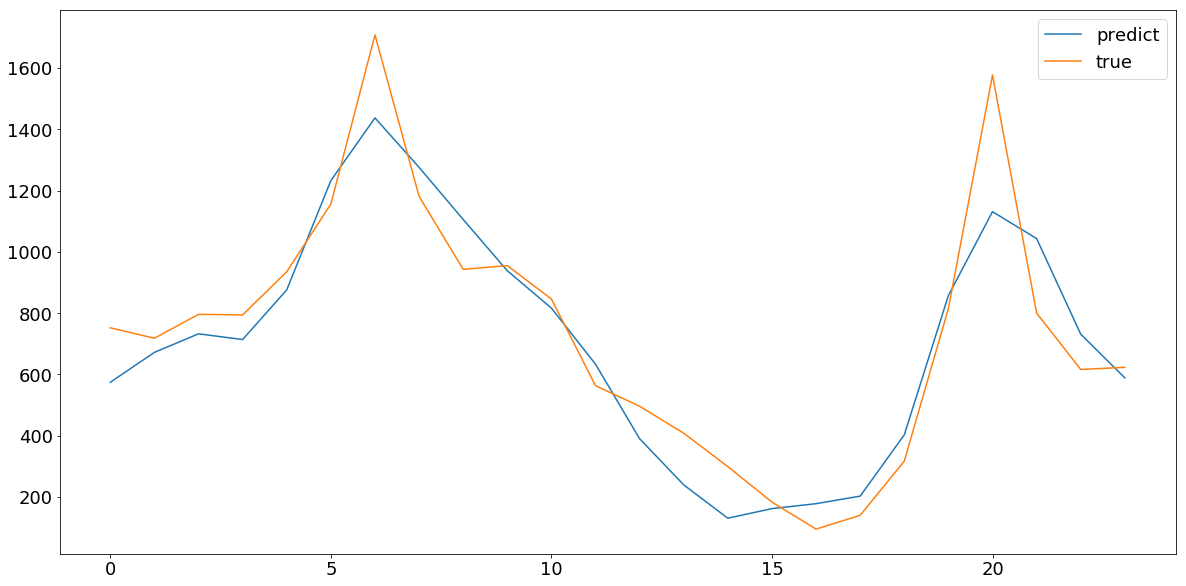

In [196]:
plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')
pyplot.legend()
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

pyplot.show()

In [197]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [198]:
columns=cols
X_test=testX.copy()
id_=24*9
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,9], In[1]: [4,240] [Op:MatMul] name: model_25/lstm_48/MatMul/